# Machine Learning

Aim:
Task 1: Genre Classification
Predict the track_genre from audio features (supervised ML)
Task 2: Song Recommendation
Recommend similar songs based on audio similarity (unsupervised ML)

## Step 1: Import Libraries

In [2]:
# Import libraries

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ML models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Recommendation
from sklearn.neighbors import NearestNeighbors

## Step 2: Load Dataset

In [3]:
df = pd.read_csv('../data/03_spotify_cleaned_dataset.csv')

Inspecting data types in 'X'

In [7]:
X.dtypes


popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
popularity_bin       object
danceability_bin     object
energy_bin           object
dtype: object

## Step 3: Prepare Data for Genre Classification

- X will contain only the raw numeric features (e.g., popularity, danceability, energy, etc.)
- y will contain encoded genre labels (e.g., 0 = "pop", 1 = "rock", ...)
- X_scaled is the input to feed into your ML model

Step 3.1: Select features (X) and drop irrelevant columns

In [ ]:
# - 'artists', 'album_name', 'track_name': Text data (requires NLP to be useful)
# - 'track_genre': This is the target variable
# - 'popularity_bin', 'danceability_bin', 'energy_bin': Manually created bins (categorical, not useful for raw ML modeling)

X = df.drop(columns=[
    'artists', 'album_name', 'track_name',
    'track_genre',
    'popularity_bin', 'danceability_bin', 'energy_bin'  # drop derived text bins
])

Step 3.2: Prepare target variable (y)

In [9]:
# We encode the track genre as numbers (ML models need numeric targets)
le = LabelEncoder()
y = le.fit_transform(df['track_genre'])

Step 3.3: Normalise Numeric Feature Values

In [10]:
# Scaling features ensures all numerical columns have similar ranges. This is especially important for algorithms sensitive to magnitude
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 4: Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


## Step 5: Train Classifier (Random Forest)

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

## Step 6: Evaluate Classification Performance

In [14]:
# Decode labels for readability
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))



Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.26      0.26      0.26       200
         afrobeat       0.37      0.37      0.37       200
         alt-rock       0.03      0.03      0.03       200
      alternative       0.11      0.10      0.11       200
          ambient       0.31      0.33      0.32       200
            anime       0.27      0.19      0.22       200
      black-metal       0.52      0.59      0.55       200
        bluegrass       0.41      0.58      0.48       200
            blues       0.13      0.08      0.10       200
           brazil       0.06      0.05      0.05       200
        breakbeat       0.57      0.51      0.54       200
          british       0.16      0.07      0.10       200
         cantopop       0.28      0.29      0.29       200
    chicago-house       0.58      0.60      0.59       200
         children       0.48      0.53      0.50       200
            chill       0.19    

## Summary of Classification Report

The classification report provides detailed performance metrics for each music genre in the dataset, including precision, recall, and F1-score:
 * Precision measures how many of the songs predicted as a certain genre actually belong to that genre.
 * Recall measures how many songs of a genre were correctly identified out of all songs in that genre.
 * F1-score balances precision and recall into a single metric.

Given the large number of genres (over 100), the overall accuracy (~33%) reflects the challenge of this multi-class classification problem. Some genres, like comedy and black-metal, achieve higher scores, indicating the model predicts these more reliably. Others, such as alt-rock and brazil, have low scores, suggesting the model struggles to differentiate these genres based on the current features.



## Next Steps:

Create a visualisation for F1-Score by Genre. Reasons:
 - With so many genres, a confusion matrix is overwhelming and unreadable.
 - A bar chart of F1-scores quickly highlights which genres the model handles well or poorly.
 - It helps identify opportunities for improvement or genres that may need more data or features.


In [15]:
# Generate classification report as a dict
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

In [16]:
# Convert to DataFrame for easier manipulation
df_report = pd.DataFrame(report).transpose()

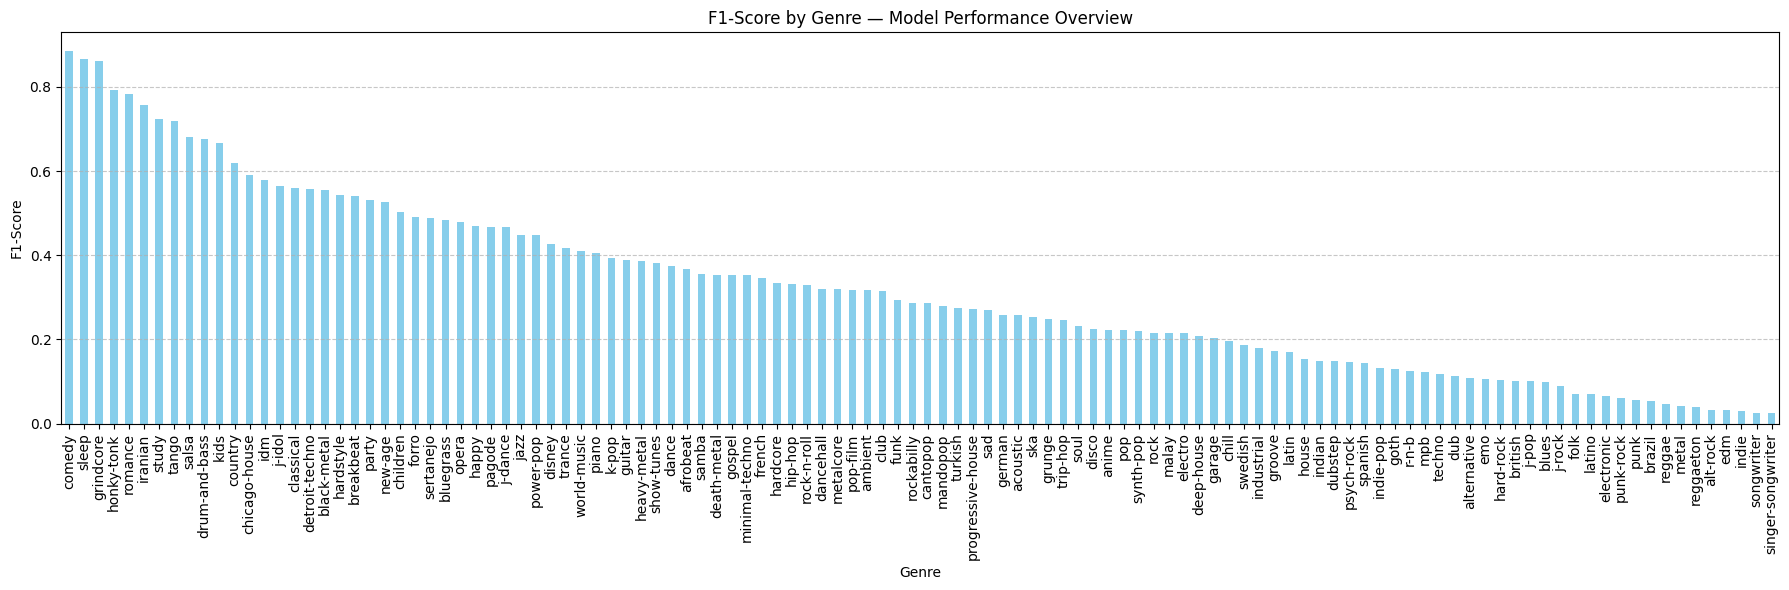

In [17]:
# Plot F1-scores of each genre, sorted from highest to lowest
plt.figure(figsize=(18,6))
df_report.iloc[:-3]['f1-score'].sort_values(ascending=False).plot(
    kind='bar', color='skyblue'
)
plt.title('F1-Score by Genre — Model Performance Overview')
plt.ylabel('F1-Score')
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary:
- This bar chart displays the F1-score for each music genre predicted by our model, sorted from highest to lowest.
- The F1-score balances precision and recall, providing a single metric to understand how well the model classifies each genre.
- Higher scores indicate genres that the model predicts reliably, while lower scores highlight genres that are more challenging.

Focusing on the top-performing genres helps simplify the classification task and improves prediction accuracy, making it ideal for practical applications like music recommendation or user-facing dashboards.

Next Steps:
 - Focus on Top Genres (Select the top 10 or 15 genres with the highest F1-scores.)
 - Retrain the model only on these genres to get better accuracy and easier predictions.

## Step 7: Song Recommendation System (Using Audio Features)

We'll use K-Nearest Neighbors to find songs that are similar based on features like danceability, energy, valence, etc.

In [ ]:
# Use the same features and scaling
audio_features = scaler.fit_transform(X)

# Fit KNN model
knn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 6 so first result is itself + 5 recommendations
knn.fit(audio_features)


Recommendation Function

In [ ]:
def recommend_song(song_index, df_original, model, features_scaled):
    distances, indices = model.kneighbors([features_scaled[song_index]])
    print(f"\nSelected Song: {df_original.iloc[song_index]['track_name']} - {df_original.iloc[song_index]['artists']}\n")
    print("Recommended Songs:\n")
    for idx in indices[0][1:]:  # skip first (it's the input song itself)
        row = df_original.iloc[idx]
        print(f"{row['track_name']} - {row['artists']} (Genre: {row['track_genre']})")


In [ ]:
Examlple song index to recommend 
# Recommend songs similar to the 10th track in the dataset
recommend_song(10, df, knn, audio_features)
